In [6]:
# Importation du DataFrame enrichi (CVE + EPSS + ANSSI)
import pandas as pd


df = pd.read_csv("DataFrame.csv", encoding="utf-8")


df['CVSS_score'] = pd.to_numeric(df['CVSS_score'], errors='coerce')
df['EPSS_score'] = pd.to_numeric(df['EPSS_score'], errors='coerce')
df['Base_Severity'] = df['Base_Severity'].str.strip().str.capitalize()

df = df.dropna(subset=['CVSS_score', 'EPSS_score', 'Base_Severity'])


df = df[df['Base_Severity'].isin(['Low', 'Medium', 'High', 'Critical'])]



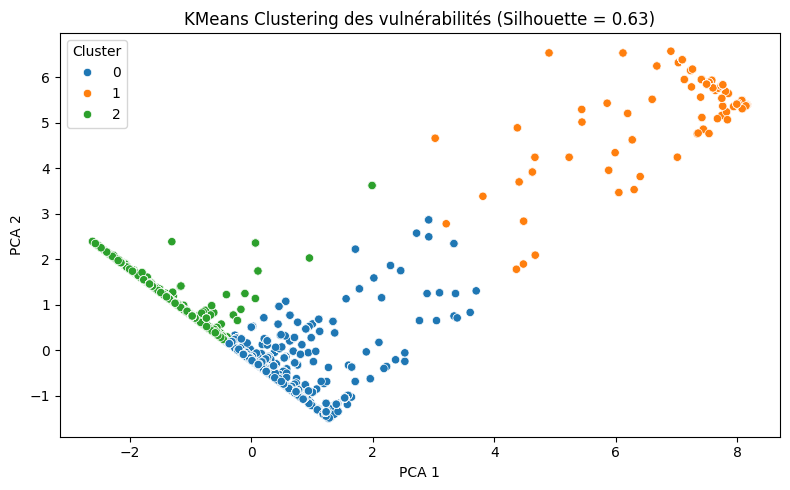

In [7]:
# Clustering non supervisé avec KMeans (EPSS vs CVSS)

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

# Sélection des variables numériques
X_unsup = df[['CVSS_score', 'EPSS_score']].dropna()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_unsup)

# Modèle KMeans
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_scaled)
df['cluster'] = clusters

# Score de silhouette
silhouette = silhouette_score(X_scaled, clusters)

# Réduction de dimension pour visualisation
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Affichage
plt.figure(figsize=(8, 5))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=clusters, palette='tab10')
plt.title(f"KMeans Clustering des vulnérabilités (Silhouette = {silhouette:.2f})")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()

Clustering non supervisé avec KMeans

Objectif : Regrouper les vulnérabilités en profils types selon leur score de gravité (CVSS) et leur exploitabilité (EPSS),
sans utiliser l’étiquette de gravité définie par l’ANSSI.

Choix technique :
- KMeans est un algorithme simple, rapide et efficace pour regrouper les données numériques.
- On standardise les variables pour éviter qu’un score domine l’autre.
- On visualise les groupes via une réduction de dimension (PCA).

Validation :
- On utilise le score de silhouette pour évaluer la cohérence des clusters.
- Une analyse complémentaire par cluster pourrait révéler des profils de vulnérabilités homogènes.

              precision    recall  f1-score   support

    Critical       1.00      1.00      1.00       452
        High       1.00      1.00      1.00      6623
         Low       1.00      1.00      1.00       430
      Medium       1.00      1.00      1.00      4031

    accuracy                           1.00     11536
   macro avg       1.00      1.00      1.00     11536
weighted avg       1.00      1.00      1.00     11536



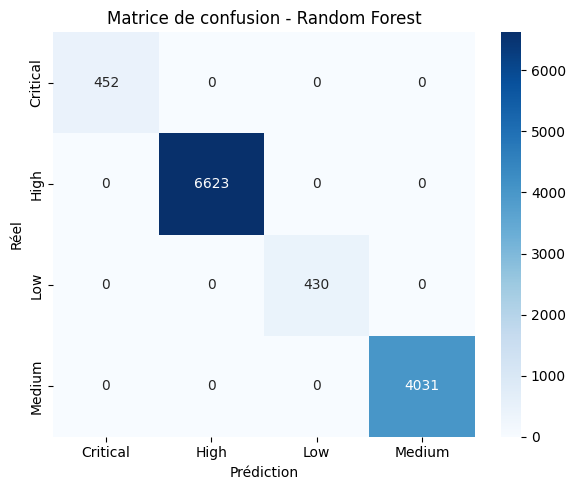

In [8]:
#  Modèle supervisé : prédire la gravité d'une vulnérabilité
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

# Nettoyage des labels
df_filtered = df[df['Base_Severity'].isin(['Low', 'Medium', 'High', 'Critical'])].dropna(subset=['CVSS_score', 'EPSS_score'])

# Préparation des données
X = df_filtered[['CVSS_score', 'EPSS_score']]
y = df_filtered['Base_Severity']

# Encodage des labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42)

# Entraînement du modèle
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

# Rapport de classification
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Matrice de confusion - Random Forest")
plt.xlabel("Prédiction")
plt.ylabel("Réel")
plt.tight_layout()
plt.show()

Classification supervisée avec RandomForestClassifier

Objectif : Prédire le niveau de gravité (Base_Severity) d’une vulnérabilité en se basant uniquement sur des variables disponibles dès l’annonce (CVSS + EPSS).

Choix du modèle :
- Random Forest : robuste aux outliers, efficace sans gros paramétrage, capable d’estimer l’importance des variables.
- On encode la variable cible (Base_Severity) et on fait un split train/test (70% / 30%).

Validation :
- Rapport de classification (précision, rappel, F1-score) pour chaque classe.
- Matrice de confusion pour évaluer les erreurs du modèle.

Limite :
- La gravité "Base_Severity" est fortement liée à CVSS, donc le modèle risque d’apprendre une redondance.
- D'autres variables qualitatives (CWE, éditeur) pourraient être intégrées pour augmenter la richesse.